In [9]:
import os
import sys
import types

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

try:
    import soundfile as sf
    import librosa
except:   
    # libsndfile is not in the default conda repo, so we have to add conda-forge
    !conda config --add channels conda-forge
    !conda install -y libsndfile
    !pip install soundfile
    !pip install librosa

    import soundfile as sf
    import librosa

try:
    import pywt
except:
    !pip install pywt
    import pywt    
    

    
%matplotlib inline

In [10]:
def __iter__(self): return 0

#
# INSERT YOUR CONNECTION TO audio_data.zip HERE
# USE Insert StreamingBody object
#
zip_file = ZipFile('audio_data.zip', 'r')
# data_bytes = BytesIO(streaming_body_1.read())
# zip_file = ZipFile(data_bytes)

The data used for this demonstration comes from the Urban Sounds Dataset. This dataset and its taxonomy is presented in J. Salamon, C. Jacoby and J. P. Bello, A Dataset and Taxonomy for Urban Sound Research, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

For simplicity the dataset is sampled and a subset of 20 audio clips from two categories are used - air conditioner (AC) and drill.

In [11]:
ZipFile.namelist(zip_file)

['audio_data/',
 'audio_data/ac/',
 'audio_data/ac/101729-0-0-1.wav',
 'audio_data/ac/101729-0-0-11.wav',
 'audio_data/ac/101729-0-0-12.wav',
 'audio_data/ac/101729-0-0-13.wav',
 'audio_data/ac/101729-0-0-14.wav',
 'audio_data/ac/101729-0-0-16.wav',
 'audio_data/ac/101729-0-0-17.wav',
 'audio_data/ac/101729-0-0-18.wav',
 'audio_data/ac/101729-0-0-19.wav',
 'audio_data/ac/101729-0-0-21.wav',
 'audio_data/ac/101729-0-0-22.wav',
 'audio_data/ac/101729-0-0-23.wav',
 'audio_data/ac/101729-0-0-24.wav',
 'audio_data/ac/101729-0-0-26.wav',
 'audio_data/ac/101729-0-0-28.wav',
 'audio_data/ac/101729-0-0-29.wav',
 'audio_data/ac/101729-0-0-3.wav',
 'audio_data/ac/101729-0-0-32.wav',
 'audio_data/ac/101729-0-0-33.wav',
 'audio_data/ac/101729-0-0-36.wav',
 'audio_data/drill/',
 'audio_data/drill/103199-4-0-0.wav',
 'audio_data/drill/103199-4-0-3.wav',
 'audio_data/drill/103199-4-0-4.wav',
 'audio_data/drill/103199-4-0-5.wav',
 'audio_data/drill/103199-4-0-6.wav',
 'audio_data/drill/103199-4-1-0.wav

In [12]:
ZipFile.namelist(zip_file)

['audio_data/',
 'audio_data/ac/',
 'audio_data/ac/101729-0-0-1.wav',
 'audio_data/ac/101729-0-0-11.wav',
 'audio_data/ac/101729-0-0-12.wav',
 'audio_data/ac/101729-0-0-13.wav',
 'audio_data/ac/101729-0-0-14.wav',
 'audio_data/ac/101729-0-0-16.wav',
 'audio_data/ac/101729-0-0-17.wav',
 'audio_data/ac/101729-0-0-18.wav',
 'audio_data/ac/101729-0-0-19.wav',
 'audio_data/ac/101729-0-0-21.wav',
 'audio_data/ac/101729-0-0-22.wav',
 'audio_data/ac/101729-0-0-23.wav',
 'audio_data/ac/101729-0-0-24.wav',
 'audio_data/ac/101729-0-0-26.wav',
 'audio_data/ac/101729-0-0-28.wav',
 'audio_data/ac/101729-0-0-29.wav',
 'audio_data/ac/101729-0-0-3.wav',
 'audio_data/ac/101729-0-0-32.wav',
 'audio_data/ac/101729-0-0-33.wav',
 'audio_data/ac/101729-0-0-36.wav',
 'audio_data/drill/',
 'audio_data/drill/103199-4-0-0.wav',
 'audio_data/drill/103199-4-0-3.wav',
 'audio_data/drill/103199-4-0-4.wav',
 'audio_data/drill/103199-4-0-5.wav',
 'audio_data/drill/103199-4-0-6.wav',
 'audio_data/drill/103199-4-1-0.wav

In [20]:
ZipFile.namelist(zip_file)
audio_data = []
labels = []
sampling_rate = []
file_names = []

for file_name in ZipFile.namelist(zip_file):
    # Skip directories
    if not os.path.basename(file_name):
        continue
    
    audio_file = None
    if file_name.startswith("audio_data/ac/"):
        labels.append(0)
        audio_file = zip_file.open(file_name)
    elif file_name.startswith("audio_data/drill/"):
        labels.append(1)
        audio_file = zip_file.open(file_name)
    else:
        print("Unknown file class. Skipping.")

    if audio_file is not None:
        file_names.append(file_name)
        tmp = BytesIO(audio_file.read())
        data, samplerate = sf.read(tmp)
        audio_data.append(data)
        sampling_rate.append(samplerate)   

In [21]:
for index in range(len(audio_data)):
    
    if (sampling_rate[index] == 48000):
        audio_data[index] = librosa.resample(audio_data[index], 48000, 44100)
        sampling_rate[index] = 44100


In [22]:
def to_mono(data):
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    return data

for index in range(len(audio_data)):
    audio_data[index] = to_mono(audio_data[index])

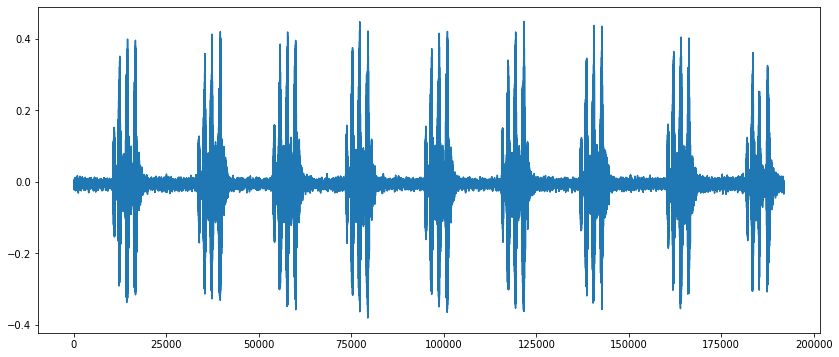

In [23]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[1])

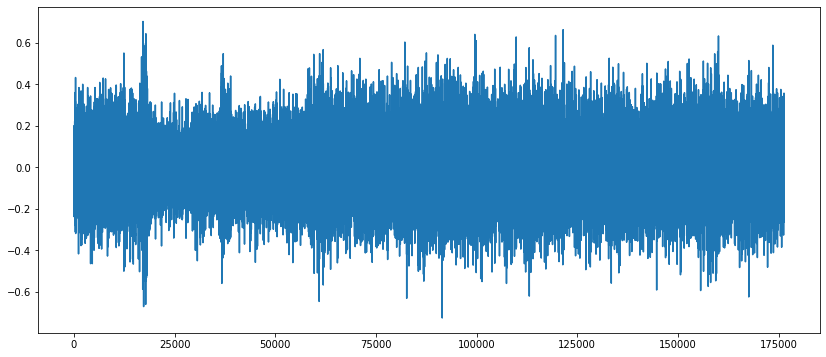

In [24]:
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[21])

In [25]:
scales = np.arange(1, 101)
coeff1, freqs1 = pywt.cwt(audio_data[1][:25000],scales, 'morl')
coeff2, freqs2 = pywt.cwt(audio_data[21][:25000], scales, 'morl')

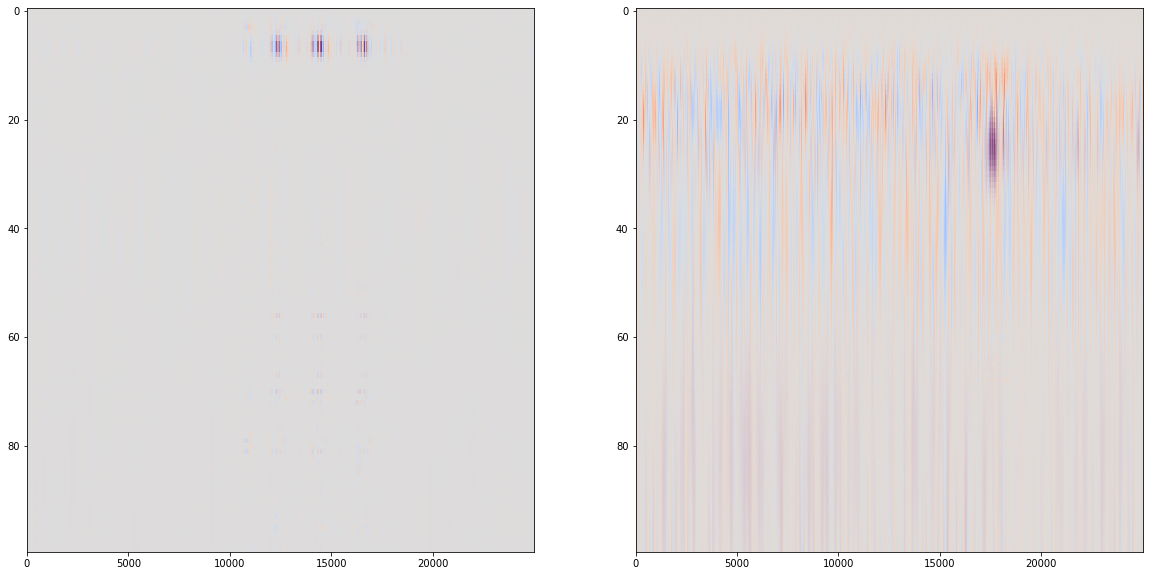

In [26]:
plt.figure(1, figsize=(20,10))
plt.subplot(121)
plt.imshow(coeff1, cmap='coolwarm', aspect='auto')  
plt.subplot(122)
plt.imshow(coeff2, cmap='coolwarm', aspect='auto')  

plt.show() 

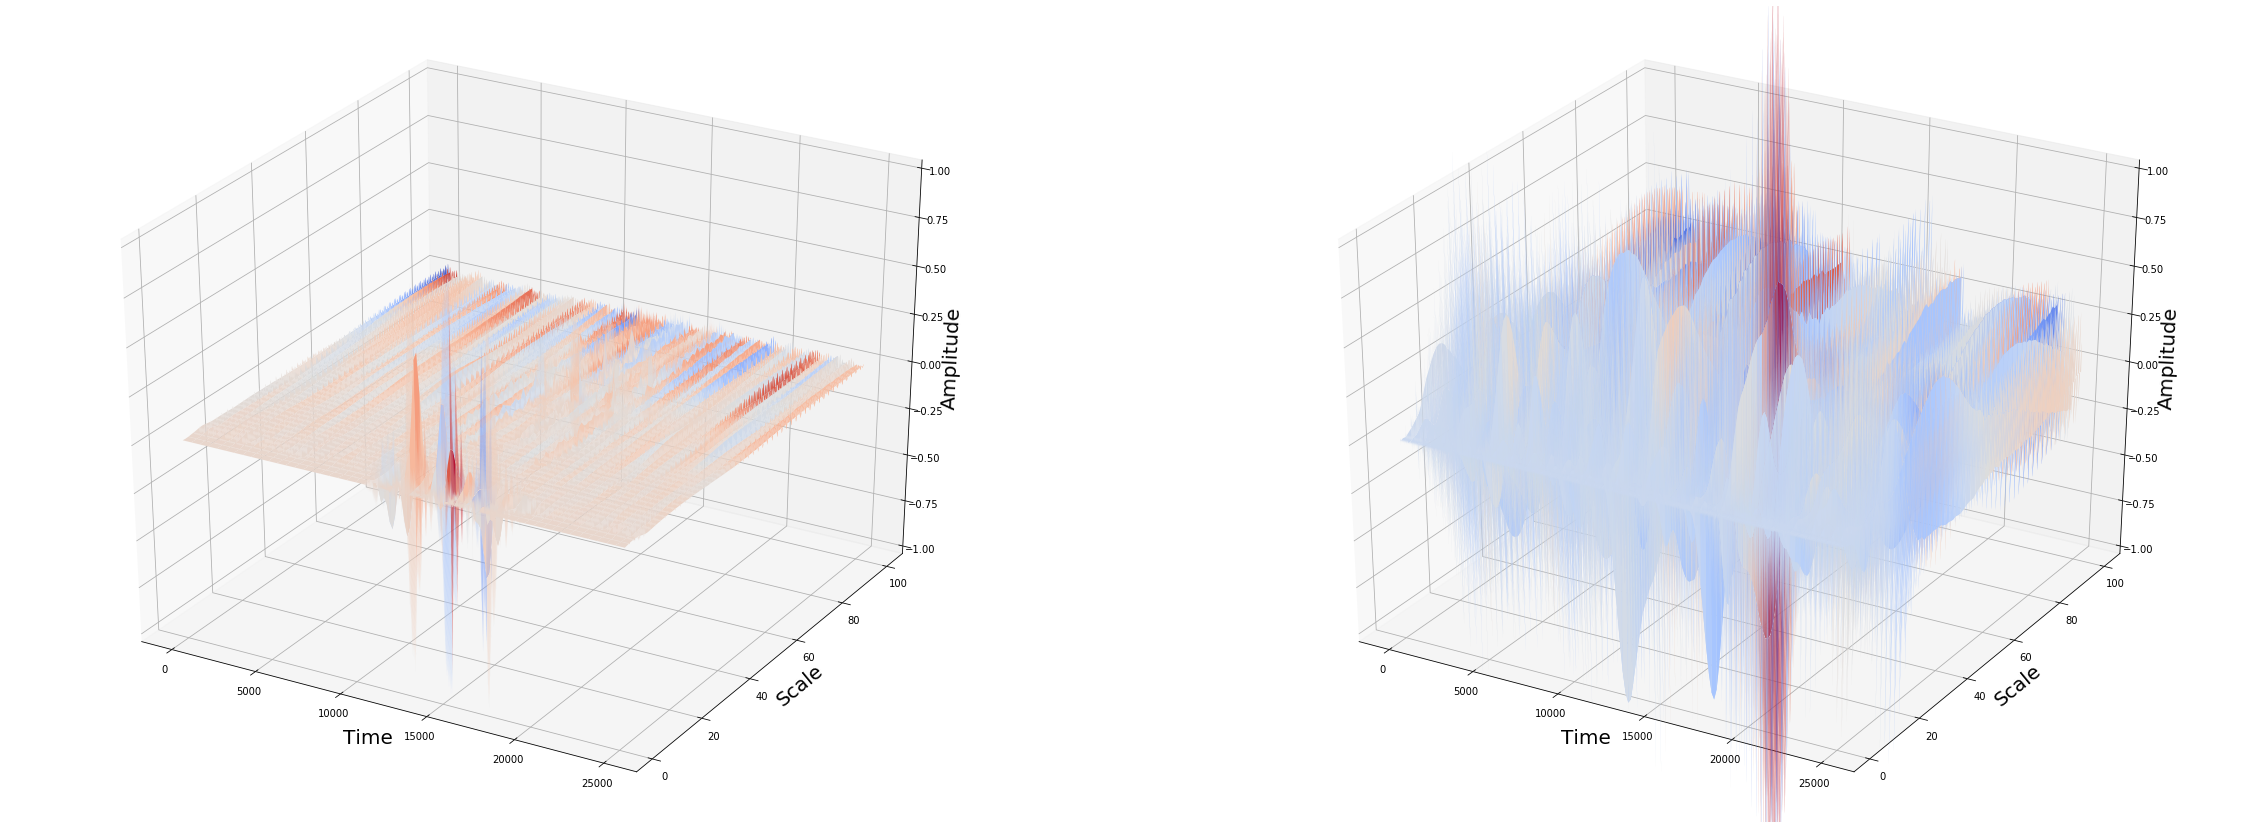

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(40,15))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

Y = np.arange(1, 101, 1)
X = np.arange(1, 25001, 1)

X, Y = np.meshgrid(X, Y)

ax1.plot_surface(X, Y, coeff1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_xlabel("Time", fontsize=20)
ax1.set_ylabel("Scale", fontsize=20)
ax1.set_zlabel("Amplitude", fontsize=20)
ax1.set_zlim3d(-1,1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot_surface(X, Y, coeff2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


ax2.set_xlabel("Time", fontsize=20)
ax2.set_ylabel("Scale", fontsize=20)
ax2.set_zlabel("Amplitude", fontsize=20)
ax2.set_zlim3d(-1,1)

plt.show()

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

features = np.empty((0,100))

for ind in range(len(audio_data)):
    print('.', end='')
    coeff, freqs = pywt.cwt(audio_data[ind][:25000], scales, 'morl')    
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])


........................................

In [29]:
features = []
for ind in range(len(audio_data)):
    coeffs = pywt.wavedec(audio_data[ind][:100000], 'db2', level=2, mode='per')
    cA2, cD2, cD1 = coeffs
    features.append(cA2) 
print(features," \n shape of features: ", np.shape(features))


[array([ 0.00454793, -0.00175474,  0.03037271, ..., -0.00761754,
       -0.02925013, -0.03754772]), array([ 0.00747419, -0.03926923, -0.03003628, ..., -0.0013266 ,
       -0.00789988, -0.03083632]), array([-0.02244112, -0.02820565, -0.05487315, ..., -0.00227514,
       -0.01328999, -0.0150898 ]), array([-0.01273742, -0.01552216, -0.01789595, ..., -0.01325035,
        0.01741533,  0.01845495]), array([ 0.00335755, -0.01428305,  0.02243466, ..., -0.00483986,
        0.00231643,  0.0293873 ]), array([-0.00376809,  0.00818777,  0.00917607, ..., -0.00455511,
       -0.01692135, -0.00529102]), array([-0.00421714, -0.04632871,  0.02680176, ..., -0.01023458,
       -0.00962834, -0.01116517]), array([-0.01288627, -0.00664748, -0.00668076, ..., -0.03838974,
        0.00678849, -0.04788111]), array([ 0.05555307, -0.16380754,  0.19745609, ..., -0.01159006,
       -0.00187616, -0.01105037]), array([ 0.19005567, -0.14635052,  0.04497502, ..., -0.01480766,
       -0.02713245, -0.05079315]), array([-0

## Discrete Wavelet Transform

Now let's plot our compressed time series data and see whether or not we obtained a good representation of our original time series data. As you can see the shapes of compressed and original signals are fairly similary to each other. Moreover, we have managed to compressed our data while respecting the time axis. 

<img src="./figs/DWT.eps" width="600">

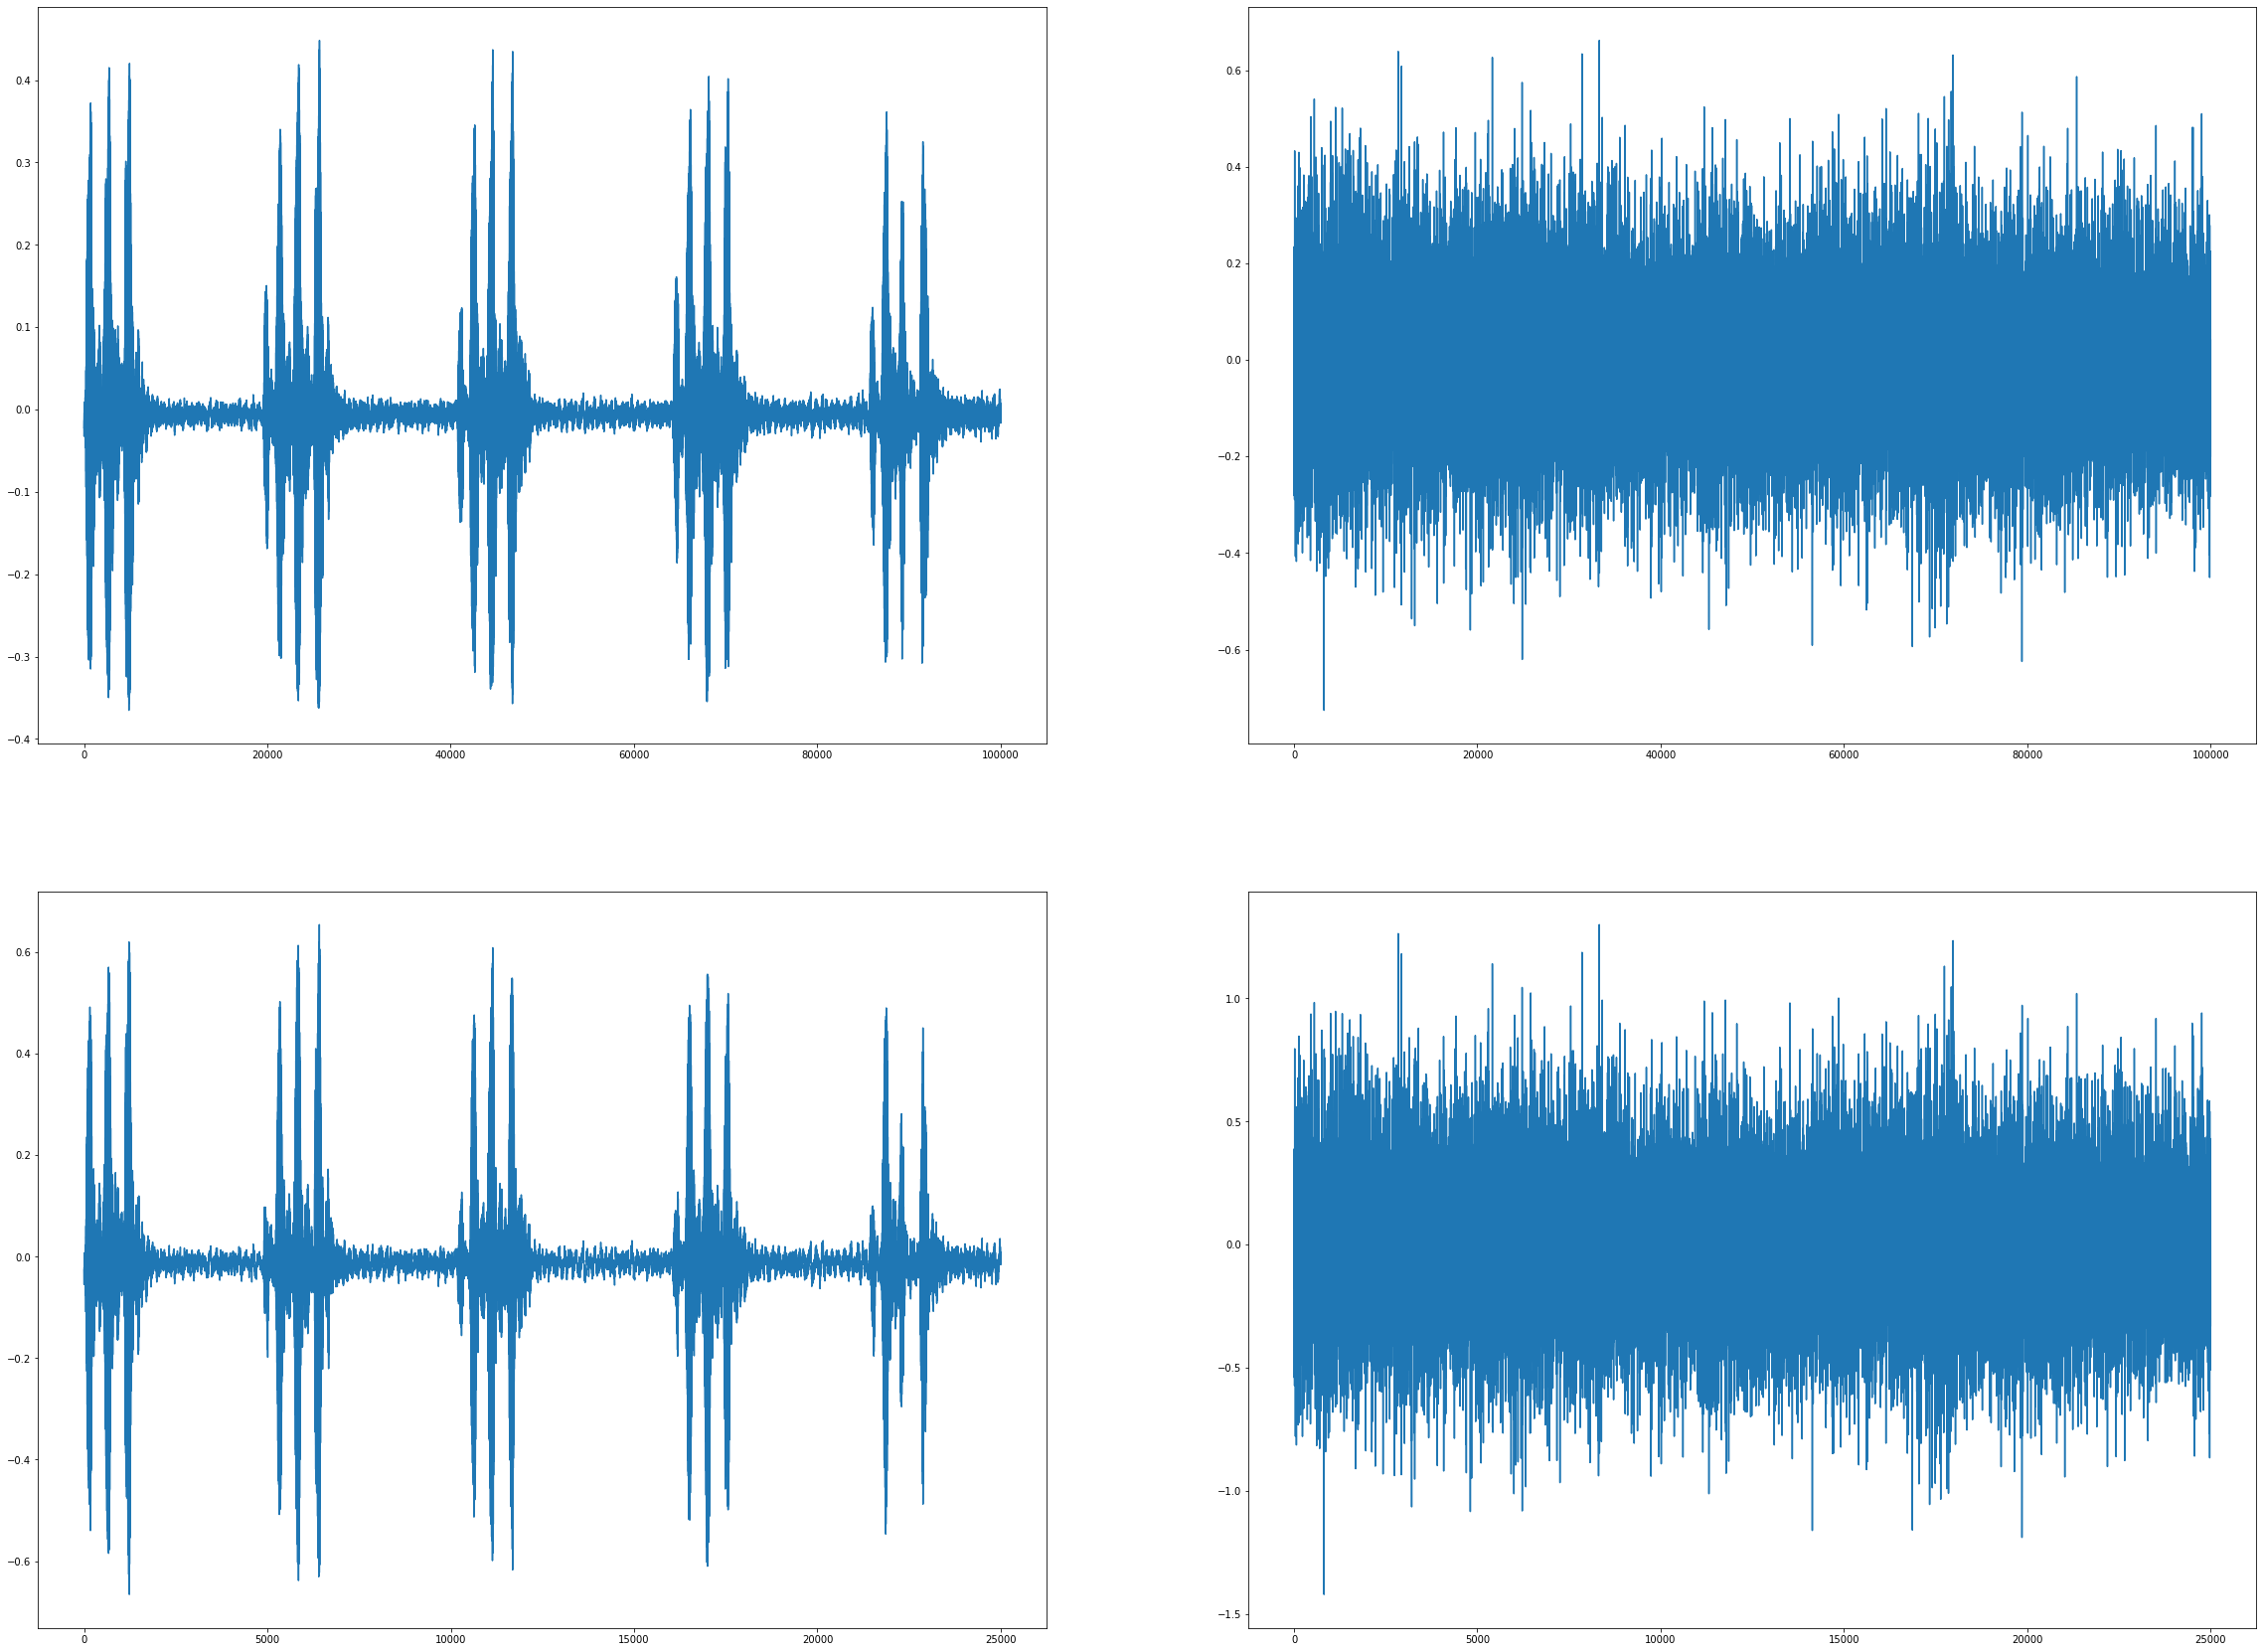

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


fig = plt.figure(figsize=(40,30))

plt.subplot(2, 2, 1)
plt.plot(audio_data[2][:100000])

plt.subplot(2, 2, 3)
plt.plot(features[2])

plt.subplot(2, 2, 2)
plt.plot(audio_data[22][:100000])

plt.subplot(2, 2, 4)
plt.plot(features[22])

plt.show()



plt.show()

# Exercise!

Compute the Haar wavelet approximations and details of the following time series data for level 2 by first using the python wavelet library, and then manually by writing down the calculations for each level. X = [4,6,10,12,8,6,5,5]

# Exercise!

Let's combine our knowledge with audio analysis and revisit our previous notes. I want you to use a machine learning technique (e.g. SVM lib from sklearn) that you are familiar with and classify the audio feature set and labels you obtained above. You need to use the "features" and "labels" variables!

## Symbolic Aggregate Approximation (SAX)

<img src="./figs/sax_transform.png" width="600">

SAX algorithm transforms a time-series into a discretised series of letters e.g. a word. It divides a time series data into equal segments and then creates a string representation for each segment. The algorithm involves 3 main steps, namely normalisation, PAA and discretising of the aggregated data. Initially, time series data is normalised to have a mean of zero and standard deviation of one before converting it to PAA. Afterwards, PAA divides the original data into desired number of windows and calculates the average amount of data falling into each window. This results in a reduction of data size. A shorter window length n results in a better reconstruction of the original data, however more data space is needed to store the data and eventually higher energy consumption by higher communication costs. The calculation of each window of PAA segments is given as:

$Z_{i}\bar = \frac{w}{n} \sum^{\frac{n}{w}i}_{j=\frac{n}{w}(i-1)+1} Z_{j}$

where $Z_{i}\bar$ represents the $i-$th element of a time series data, $Z$, of length $n$, and $w$ represents the number of segments. This results in a reduction of data size from n to $n/w$ data points. Once time series data transformed into PAA coeﬃcients, symbolising the PAA representation into a discrete string is the ﬁnal stage. Considering the fact that normalised time series data follows a Gaussian distribution, the discretisation phase allows symbolic representations of data to be obtained by mapping PAA coeﬃcients to breakpoints that are produced according to the alphabet size $a$, which in turn determines equal-sized areas under a Gaussian curve. Table given below shows the Gaussian breakpoints for values of alphabet size, $a$, from 3 to 10. The deﬁnition for breakpoints are given below:

# <font color='red'>Deﬁnition 1. (Breakpoints)</font> 
Breakpoints are a sorted list of numbers B = β, ...., β a−1 such that the area under a $N(0,1)$ Gaussian curve from $\beta_{i}$ to $\beta_{i+1} = 1/a$, where $\beta_{0}$ and $\beta_{a}$ are deﬁned as $-\infty$ and $\infty$, respectively.


<img src="./figs/breaktable.png" width="600">




The break lines are distributed vertically according to the Gaussian distribution, the ﬁrst letter of the alphabet represents the smallest PAA coeﬃcient, $a$, and the greatest PAA coeﬃcient is represented by the last letter of the alphabet. The deﬁnition to obtain the symbolic representation is given below:

Deﬁnition 2. (Word). A subsequence $C$ of length $n$ can be represented as a word $\hat{C} = \hat{c}_{1} , ...., \hat{c}_{w}$ as follows. Let  $\beta_{i}$ denote the $i−$th element of the alphabet, i.e., $\beta_{1} = a$ and $\beta_{2} = b$ then the mapping from a PAA approximation $\bar{C}$ to a word $\hat{C}$ is obtained as follows:

$\hat{c}_{i} = \beta_{j}, ⇐⇒ \beta_{j−1} ≤ \hat{c_{i}} \leq \beta_{j}$

# <font color='blue'>Example</font> 

Let’s assume that we have a time-series data, time-series $(c) = {2, 3, 4.5, 7.6}$. Following the steps given above, we apply $z$ − transform and obtain time-series $(z) ={−0.93, −0.52, 0.09, 1.36}$. Here we use SAX with window size of $2$ and alphabet size of $4$: it leads to a set of PAA coeﬃcients of ${−0.72, 0.72}$. Finally, we map the PAA coeﬃcients into SAX symbols by using the cut oﬀ ranges of $\beta$ and $\beta_{a-1}$ , given in Table above, ${−0.67, 0, 0.67}$, and obtain corresponding SAX word ${ad}$. Given that the ﬁrst PAA coeﬃcient is smaller than $−0.67$ and the second coeﬃcient is greater than $0.67$, the former is assigned to $a$ and latter to $d$.

In the following example, a real time data obtained for average speed from a pair of sensor points are normalised, discretised by ﬁrst obtaining a PAA approximation and then using predetermined breakpoints to map the PAA coeﬃcients into SAX symbols. In the example above, with $n=144$, $w=6$ and $a=5$, the time series is mapped to the words $bbdcddbdcabcbbcbcdbbdddddcc$




# Normalisation phase

<img src="./figs/1NormalisedAvgSpd.eps" width="600">





# Piecewise Aggregate Approximation (PAA) 
<img src="./figs/1PAAAvgSpd.eps" width="600">

# Discretisation
<img src="./figs/1SAXAvgSpd-eps-converted-to.pdf" width="600">

In [32]:
import sys
sys.path.insert(0, './saxpy/')
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string, sax_by_chunking, sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.paa import paa
cuts_for_asize(3)
dat = np.array([-2, 0, 2, 0, -1])
dat_znorm = znorm(dat)
dat_paa_3 = paa(dat_znorm, 3)
print(dat_paa_3)
sax=ts_to_string(dat_paa_3, cuts_for_asize(3))
print("sax words:", sax)

dat = np.array([0., 0., 0., 0., 0., -0.270340178359072, -0.367828308500142,
            0.666980581124872, 1.87088147328446, 2.14548907684624,
            -0.480859313143032, -0.72911654245842, -0.490308602315934,
            -0.66152028906509, -0.221049033806403, 0.367003418871239,
            0.631073992586373, 0.0487728723414486, 0.762655178750436,
            0.78574757843331, 0.338239686422963, 0.784206454089066,
            -2.14265084073625, 2.11325193044223, 0.186018356196443,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.519132472499234,
            -2.604783141655, -0.244519550114012, -1.6570790528784,
            3.34184602886343, 2.10361226260999, 1.9796808733979,
            -0.822247322003058, 1.06850578033292, -0.678811824405992,
            0.804225748913681, 0.57363964388698, 0.437113583759113,
            0.437208643628268, 0.989892093383503, 1.76545983424176,
            0.119483882364649, -0.222311941138971, -0.74669456611669,
            -0.0663660879732063, 0., 0., 0., 0., 0.,])


dat_znorm = znorm(dat)
dat_paa_3 = paa(dat_znorm, 8)
print(dat_paa_3)
sax=ts_to_string(dat_paa_3, cuts_for_asize(4))
print("sax words:", sax)



[-0.75377836  1.05528971 -0.30151134]
sax words: acb
[-0.25438749  0.02912198  0.14946304 -0.04464851 -0.51484423  0.50073883
  0.47372751 -0.33917113]
sax words: bccbbccb


## <font color='blue'>Exercise!</font>
I want you to plot the sax values and show the output in a figure. Ideally, the y axis will have the z-values, and x-axis will have sax output as numbers. 